# IJCAI 2025 - Higher Stakes, Higher Trust?
**Supplementary material for IJCAI25 - HAI Track - Submission ID 8976**

Notebook for running statistical analysis on particpant performance metrics.  

Be sure to update path information to location of results files. And you can skip the section "Load and Preprocess Participant Data" since this is already been processed for each participant


In [1]:
from pathlib import Path
import numpy as np 
from PIL import Image

import pandas as pd

from statannotations.Annotator import Annotator

from scipy.stats import mannwhitneyu, wilcoxon, shapiro, ttest_ind, ttest_rel, levene

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import utils
sns.set(style="whitegrid")

# Notebook and File Paths Setup

In [2]:
CLASSES = ['Healthy', 'OCDegen']
input_stages = {'0': 'training', '1': 'validation_nodiag', '2': 'validation_noxai'}
# BASEPATH = Path('ijcai25/data')
BASEPATH = Path('/Users/djohnson/zScieboArchive/1. Research/human-ai collab/ijcai25/data')

high_stakes_pth = BASEPATH / 'example_validation_study'
low_stakes_pth = BASEPATH / 'example_validation_study_ls'

stage1_pth = 'validation_nodiag/results'
stage2_pth = 'validation_noxai/results'

In [3]:
# rejected participants
filters = ['study1-59', 'study1-60']
rejected = ['study1-53', 'study1-54', 'study1-55', 'study1-56', 'study1-57', 'study1-58', 'study1-59']

def get_id(res_file: Path):
    return res_file.stem.split('_')[-1]

In [4]:
def process_results_dfs(results_dfs, stakes='hs'):
  # Create a dataframe from results_ls that includes the pid as a column
  results_comb_df = None
  for i in range(3):
    stage_df = pd.concat([df.assign(pid=pid) for pid, df in results_dfs[f'results_{stakes}_dfs_{i}'].items()])
    stage_df.reset_index(drop=True, inplace=True)
    stage_df['stage'] = i
    if results_comb_df is None:
      results_comb_df = stage_df
    else:
      results_comb_df = pd.concat([results_comb_df, stage_df])

  # Move pid to the front
  cols = ['pid'] + [col for col in results_comb_df if col != 'pid']
  results_comb_df = results_comb_df[cols]
  results_comb_df['stage'] = results_comb_df['stage'].astype('category')

  results_comb_df['pred_correct'] = results_comb_df['pred'] == results_comb_df['true']
  results_comb_df['part_correct'] = results_comb_df['select'] == results_comb_df['true']

  return results_comb_df

In [5]:
def get_results(df, stage):
    """
    Calculate the results for a given stage
    
    df: dataframe contain participant predictions
    stage: the stage to calculate the results for

    returns: a dictionary of the calculated metrics for the participant
    """

    df = df[df.stage == stage]
    
    acc = df['part_correct'].mean()
    dec_time = (df['updated'] - df['accessed_updated']).mean()

    # stage one only has an accuracy value since there is no AI and stage 0 is just for sanity checking
    if stage < 1:
       return acc, dec_time
    
    agree_cond = df['pred'] == df['select']
    disagree_cond = df['pred'] != df['select']

    correct_preds = (df['pred'] == df['true'])
    incorrect_preds = (df['pred'] != df['true'])  

    # overreliance
    or_cond = agree_cond & incorrect_preds
    overreliance = (or_cond).astype(int).sum() / incorrect_preds.astype(int).sum()

    ur_cond = disagree_cond & correct_preds
    underreliance = (ur_cond).astype(int).sum() / correct_preds.astype(int).sum()

    # agreement
    reliance = (agree_cond).astype(int).sum() / len(df)
    
    # disagreement
    disagree = (disagree_cond).astype(int).sum() / len(df)

    # healthy distrust (prev. approp. reliance)
    hdt_cond = disagree_cond & incorrect_preds
    h_distrust = (hdt_cond).astype(int).sum() / (incorrect_preds).astype(int).sum()

    # health trust
    ht_cond = agree_cond & correct_preds
    h_trust = (ht_cond).astype(int).sum() / (correct_preds).astype(int).sum()

    return acc, reliance, overreliance, underreliance, disagree, h_distrust, h_trust, dec_time

def get_part_results(res_df, pids):
  dfs = []
  for pid in pids:
    acc0, dec_time0 = get_results(res_df[res_df['pid'] == pid], 0)
    acc1, reliance1, overreliance1, underreliance1, disagree1, h_distrust1, h_trust1, dec_time1 = get_results(res_df[res_df['pid'] == pid], 1)
    acc2, reliance2, overreliance2, underreliance2, disagree2, h_distrust2, h_trust2, dec_time2 = get_results(res_df[res_df['pid'] == pid], 2)

    results = dict(
      id = pid,
      accuracy0 = acc0,
      accuracy1 = acc1,
      reliance1 = reliance1,
      overreliance1 = overreliance1,
      underreliance1 = underreliance1,
      healthy_distrust1 = h_distrust1,
      healthy_trust1 = h_trust1,
      accuracy2 = acc2, 
      reliance2 = reliance2,
      overreliance2 = overreliance2,
      underreliance2 = underreliance2,
      healthy_distrust2 = h_distrust2,
      healthy_trust2 = h_trust2,
      dec_time0 = dec_time0,
      dec_time1 = dec_time1,
      dec_time2 = dec_time2
    )
    
    dfs.append(pd.DataFrame([results]))

  df = pd.concat(dfs, ignore_index=True)
  df.set_index('id', inplace=True)
  return df

# Load and Preprocess Participant Data

Skip these cells if particpant performance metrics have already been processed and you are loading from a CSV

In [6]:
# ids from final stage to ensure completion
ids_hs = [get_id(f) for f in (high_stakes_pth / stage2_pth).rglob('*.csv') if get_id(f) not in filters + rejected]
ids_ls = [get_id(f) for f in (low_stakes_pth / stage2_pth).rglob('*.csv') if get_id(f) not in filters + rejected]

print(len(ids_hs), len(ids_ls))

28 24


In [7]:
#load all participants predictions to dataframes
results_ls = dict(
  results_ls_dfs_0 = {id: pd.read_csv(low_stakes_pth / input_stages['0'] / 'results' / f'results_{input_stages["0"]}_{id}.csv') for id in ids_ls},
  results_ls_dfs_1 = {id: pd.read_csv(low_stakes_pth / input_stages['1'] / 'results' / f'results_{input_stages["1"]}_{id}.csv') for id in ids_ls},
  results_ls_dfs_2 = {id: pd.read_csv(low_stakes_pth / input_stages['2'] / 'results' / f'results_{input_stages["2"]}_{id}.csv') for id in ids_ls},
)

results_hs = dict(
  results_hs_dfs_0 = {id: pd.read_csv(high_stakes_pth / input_stages['0'] / 'results' / f'results_{input_stages["0"]}_{id}.csv') for id in ids_hs},
  results_hs_dfs_1 = {id: pd.read_csv(high_stakes_pth / input_stages['1'] / 'results' / f'results_{input_stages["1"]}_{id}.csv') for id in ids_hs},
  results_hs_dfs_2 = {id: pd.read_csv(high_stakes_pth / input_stages['2'] / 'results' / f'results_{input_stages["2"]}_{id}.csv') for id in ids_hs},
)

assert results_ls['results_ls_dfs_0'].keys() == results_ls['results_ls_dfs_1'].keys() == results_ls['results_ls_dfs_2'].keys()
assert results_hs['results_hs_dfs_0'].keys() == results_hs['results_hs_dfs_1'].keys() == results_hs['results_hs_dfs_2'].keys()

In [8]:
results_ls_comb_df = process_results_dfs(results_ls, stakes='ls')
results_ls_comb_df['stakes'] = 'ls'
results_ls_comb_df = results_ls_comb_df.dropna()
results_hs_comb_df = process_results_dfs(results_hs, stakes='hs')
results_hs_comb_df['stakes'] = 'hs'
results_hs_comb_df = results_hs_comb_df.dropna()


results_full_df = pd.concat([results_ls_comb_df, results_hs_comb_df])
results_full_df = results_full_df.dropna()

In [9]:
pids_ls = list(results_ls_comb_df['pid'].unique())
pids_hs = list(results_hs_comb_df['pid'].unique())

part_res_ls_df = get_part_results(results_ls_comb_df, pids_ls)
part_res_hs_df = get_part_results(results_hs_comb_df, pids_hs)

part_res_ls_df['Decision Stakes'] = 'Low Stakes'
part_res_hs_df['Decision Stakes'] = 'High Stakes'

comb_df = pd.concat([part_res_ls_df, part_res_hs_df])
comb_df.to_csv(BASEPATH / 'participant_results.csv')


# Statisical Analysis and Figures

In [10]:
## Functions for effect size
def cohen_r_mwu(g1, g2, u):
    n1, n2 = len(g1), len(g2)
    mu_u = n1 * n2 / 2
    sigma_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    
    z= (u - mu_u) / sigma_u
    return z / np.sqrt(n1 + n2)

def cohen_r_wilcoxon(t1, t2, statistic):
    n = len([tt1-tt2 for tt1, tt2 in zip(t1, t2) if tt1 != tt2])
    mu_w = n * (n + 1) / 4
    sigma_w = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)

    z = (statistic - mu_w) / sigma_w
    return z / np.sqrt(n)

def cohen_d_ind(g1, g2, stat):
    n1, n2 = len(g1), len(g2)
    s1, s2 = np.std(g1, ddof=1), np.std(g2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    mean_diff = np.mean(g1) - np.mean(g2)
    return mean_diff / pooled_std

def cohen_d_rel(t1, t2, stat):
    differences = np.array(t1) - np.array(t2)
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)

    return mean_diff / std_diff
    


def run_stats(df, cols, test, effect_fn, design='group'):
    '''
      Run statistical tests on the data
      
      df: DataFrame
      cols: List of columns to test
      test: Statistical test to run
      effect_fn: Function to calculate effect size
      design: 'group' for independent samples, 'paired' for dependent samples, 'normality' for normality test
      returns: p-values for comparied conditions
    '''
    
    df_hs = df[df['Decision Stakes'] == 'High Stakes']
    df_ls = df[df['Decision Stakes'] == 'Low Stakes']
    
    p_values_1 = []
    p_values_2 = []
    for c in cols:
        if design == 'group':
            print(f'####### {c} - Group Design - Independent - {test.__name__} #######')
            stat, p = test(df_hs[c], df_ls[c])
            if '1' in c:
                p_values_1.append(p)  
            elif '2' in c:
                p_values_2.append(p)
            effect = effect_fn(df_hs[c], df_ls[c], stat)
            print(f'Statistic={stat}, p-value={p} -- {"Significant" if p < 0.05 else "Not significant"} - Effect={effect}')
        elif design == 'paired':
            print(f'####### {c} - Paired Design - Dependent - {test.__name__} #######')
            stat, p = test(df_hs[c+'1'], df_hs[c+'2'])
            p_values_2.append(p)
            effect = effect_fn(df_hs[c+'1'], df_hs[c+'2'], stat)
            print(f'High Stakes - Statistic={stat}, p-value={p} -- {"Significant" if p < 0.05 else "Not significant"} - Effect={effect}')
            stat, p = test(df_ls[c+'1'], df_ls[c+'2'])
            p_values_1.append(p)
            effect = effect_fn(df_ls[c+'1'], df_ls[c+'2'], stat)
            print(f'Low Stakes - Statistic={stat}, p-value={p} -- {"Significant" if p < 0.05 else "Not significant"} - Effect={effect}')
        elif design == 'normality':
            print(f'####### {c} - Shapiro-Wilk Test #######')
            stat, p = test(df_hs[c])
            print(f'High Stakes Statistic={stat}, p-value={p} -- {"Normal" if p < 0.05 else "Not normal"}')
            stat, p = test(df_ls[c])
            print(f'Low Stakes Statistic={stat}, p-value={p} -- {"Normal" if p < 0.05 else "Not normal"}')
        print()

    return p_values_1, p_values_2

In [11]:
# load previously calculated participant results
combined_df = pd.read_csv(BASEPATH / 'participant_results.csv')

## Evaluation of Performance Hypotheses

### Data Processing

In [12]:
# Define the columns and labels

columns =['accuracy1', 'accuracy2', 'reliance1', 'reliance2',  'healthy_distrust1', 'healthy_distrust2', 'healthy_trust1', 'healthy_trust2']
labels = ['Acc. Baseline', 'Acc.', 'Agreement Baseline', 'Agreement', 'Healthy Distrust Baseline', 'Healthy Distrust', 'Healthy Trust Baseline',  'Healthy Trust']

# Melt the DataFrame
melted_df = pd.melt(combined_df, id_vars='Decision Stakes', value_vars=columns,
          var_name='Feature', value_name='Value')


### Analysis

In [13]:
print('##### Normality')
_ = run_stats(combined_df, columns, shapiro, design='normality', effect_fn=None)

##### Normality
####### accuracy1 - Shapiro-Wilk Test #######
High Stakes Statistic=0.9757852653872248, p-value=0.7403650079784937 -- Not normal
Low Stakes Statistic=0.9481937317243185, p-value=0.24752159541911845 -- Not normal

####### accuracy2 - Shapiro-Wilk Test #######
High Stakes Statistic=0.9486445260598173, p-value=0.1831587171657671 -- Not normal
Low Stakes Statistic=0.9645985803821808, p-value=0.5374637604351646 -- Not normal

####### reliance1 - Shapiro-Wilk Test #######
High Stakes Statistic=0.972225821937356, p-value=0.6413648390093195 -- Not normal
Low Stakes Statistic=0.9278138003425958, p-value=0.08711890723326732 -- Not normal

####### reliance2 - Shapiro-Wilk Test #######
High Stakes Statistic=0.9677825111096016, p-value=0.5225563532068717 -- Not normal
Low Stakes Statistic=0.9758191158577, p-value=0.8081991641707543 -- Not normal

####### healthy_distrust1 - Shapiro-Wilk Test #######
High Stakes Statistic=0.9105653798922477, p-value=0.020402235079206563 -- Normal
Low

In [14]:
print('##### Mann-Whitney U Test - Comparing Effects of Stakes')
pvals1, pvals2 = run_stats(combined_df, columns, mannwhitneyu, effect_fn=cohen_r_mwu, design='group')

##### Mann-Whitney U Test - Comparing Effects of Stakes
####### accuracy1 - Group Design - Independent - mannwhitneyu #######
Statistic=372.0, p-value=0.5120117873491754 -- Not significant - Effect=0.09163658174683431

####### accuracy2 - Group Design - Independent - mannwhitneyu #######
Statistic=317.0, p-value=0.7320640308605207 -- Not significant - Effect=-0.04836375147749589

####### reliance1 - Group Design - Independent - mannwhitneyu #######
Statistic=379.5, p-value=0.4277847041695162 -- Not significant - Effect=0.11072753627742479

####### reliance2 - Group Design - Independent - mannwhitneyu #######
Statistic=430.0, p-value=0.08524565884970622 -- Not significant - Effect=0.23927329678340073

####### healthy_distrust1 - Group Design - Independent - mannwhitneyu #######
Statistic=288.0, p-value=0.36806028098968535 -- Not significant - Effect=-0.12218210899577908

####### healthy_distrust2 - Group Design - Independent - mannwhitneyu #######
Statistic=229.0, p-value=0.048938589755

In [15]:
print('##### Wilcoxon Signed-Rank Test - Comparing Effects of AI')
ind_cols = ['accuracy', 'reliance', 'healthy_distrust', 'healthy_trust']
pvals_ls, pvals_hs = run_stats(combined_df, ind_cols, wilcoxon, design='paired', effect_fn=cohen_r_wilcoxon)



##### Wilcoxon Signed-Rank Test - Comparing Effects of AI
####### accuracy - Paired Design - Dependent - wilcoxon #######
High Stakes - Statistic=35.5, p-value=0.001720796700299503 -- Significant - Effect=-0.6500505055884432
Low Stakes - Statistic=34.5, p-value=0.002755712950650731 -- Significant - Effect=-0.6367963896515731

####### reliance - Paired Design - Dependent - wilcoxon #######
High Stakes - Statistic=0.0, p-value=7.450580596923828e-09 -- Significant - Effect=-0.873589088036728
Low Stakes - Statistic=0.0, p-value=2.6670445532979518e-05 -- Significant - Effect=-0.8751899489873676

####### healthy_distrust - Paired Design - Dependent - wilcoxon #######
High Stakes - Statistic=1.5, p-value=6.475959533011342e-06 -- Significant - Effect=-0.8669274776838324
Low Stakes - Statistic=1.5, p-value=0.0001648214599867307 -- Significant - Effect=-0.863209734791655

####### healthy_trust - Paired Design - Dependent - wilcoxon #######
High Stakes - Statistic=1.5, p-value=2.2351741790771484e

### IJCAI - Decision Performance Figure

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

accuracy1_Low Stakes vs. accuracy2_Low Stakes: Custom statistical test, P_val:2.756e-03
accuracy1_High Stakes vs. accuracy2_High Stakes: Custom statistical test, P_val:1.721e-03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

reliance1_Low Stakes vs. reliance2_Low Stakes: Custom statistical test, P_val:2.667e-05
reliance1_High Stakes vs. reliance2_High Stakes: Custom statistical test, P_val:7.451e-09
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

healthy_distrust2_Low Stakes vs. healthy_distrust2_High Stakes: Cust

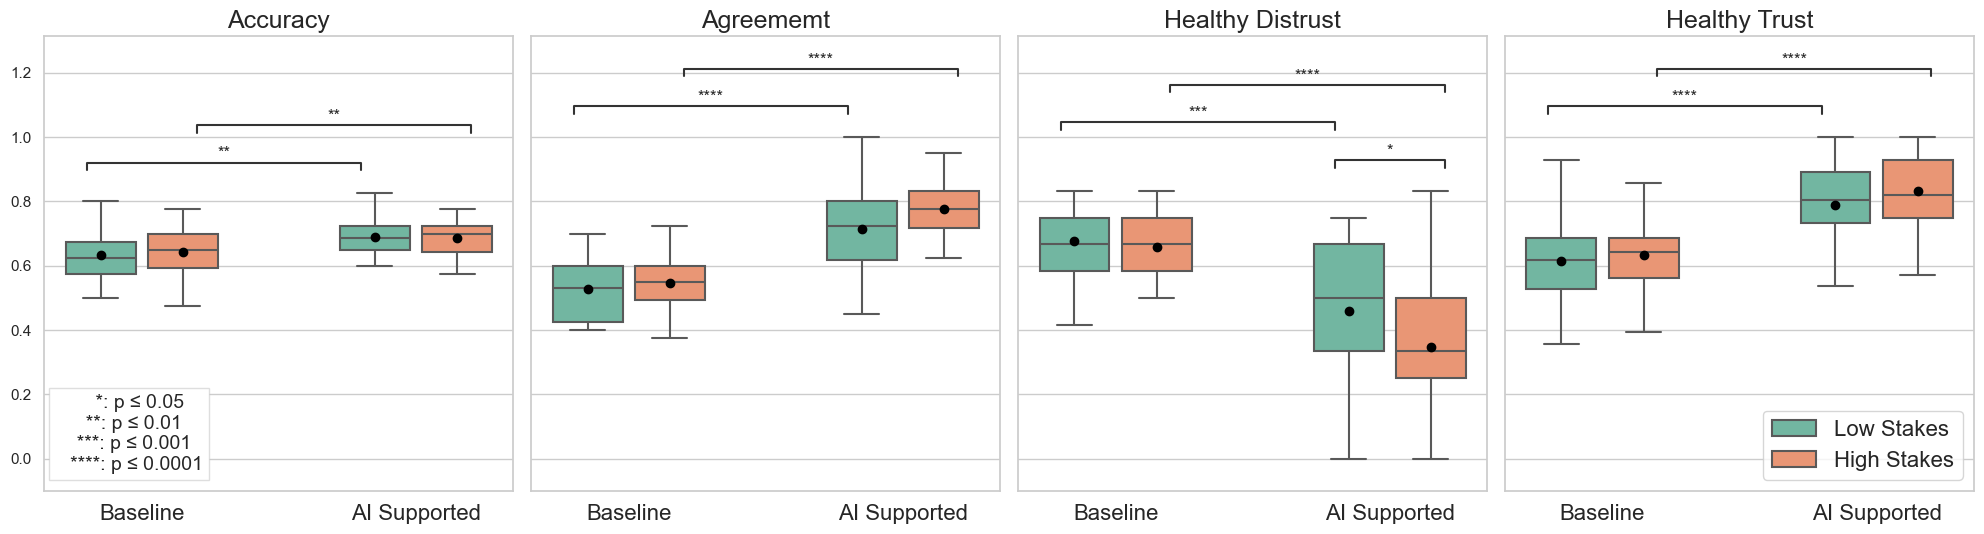

In [16]:
# Plots the Box Plots with statistical annotations via statannotations

ticks = ['Baseline', 'AI Supported']
sub_labels = ['Accuracy', 'Agreememt', 'Healthy Distrust', 'Healthy Trust']
columns =[['accuracy1', 'accuracy2'], ['reliance1', 'reliance2'], ['healthy_distrust1', 'healthy_distrust2'], ['healthy_trust1', 'healthy_trust2']]


mwu_pairs = [[(("accuracy1", "Low Stakes"), ("accuracy1", "High Stakes")),
              (("accuracy2", "Low Stakes"), ("accuracy2", "High Stakes"))],

              [(("reliance1", "Low Stakes"), ("reliance1", "High Stakes")),
               (("reliance2", "Low Stakes"), ("reliance2", "High Stakes"))],

             [(("healthy_distrust2", "Low Stakes"), ("healthy_distrust2", "High Stakes"))],

             [(("healthy_trust2", "Low Stakes"), ("healthy_trust2", "High Stakes"))]]

wil_pairs = [[(("accuracy1", "Low Stakes"), ("accuracy2", "Low Stakes")),
              (("accuracy1", "High Stakes"), ("accuracy2", "High Stakes"))],

              [(("reliance1", "Low Stakes"), ("reliance2", "Low Stakes")),
               (("reliance1", "High Stakes"), ("reliance2", "High Stakes"))],

             [(("healthy_distrust1", "Low Stakes"), ("healthy_distrust2", "Low Stakes")),
              (("healthy_distrust1", "High Stakes"), ("healthy_distrust2", "High Stakes"))],

             [(("healthy_trust1", "Low Stakes"), ("healthy_trust2", "Low Stakes")),
              (("healthy_trust1", "High Stakes"), ("healthy_trust2", "High Stakes"))]]


fig, axes = plt.subplots(1, 4, figsize=(20, 5.5), sharey=True)

for ax, l, cs, mwu_ps, wil_ps in zip(axes.flatten(), sub_labels, columns, mwu_pairs, wil_pairs):

  df_tmp = combined_df[cs + ['Decision Stakes']]
  melted_df = pd.melt(df_tmp, id_vars='Decision Stakes', value_vars=cs,
                      var_name='Feature', value_name='Value')

  box_plot = sns.boxplot(
      ax=ax,  data=melted_df, x='Feature', y='Value', hue='Decision Stakes',
      dodge='auto', width=0.6, fliersize=2, linewidth=1.5, palette='Set2', gap=0.15,
      showfliers=False, showmeans=True, meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black'),
  )
  ax.set_title(l, fontsize=18)
  ax.set_xticks(ticks=np.arange(2), labels = ticks, fontsize=16)
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_ylim([-0.1, 1.1])

  if l == 'Healthy Trust':
    ax.legend(title='', loc='lower right', fontsize=16)
  elif l == 'Accuracy':
    text ='    *: p ≤ 0.05\n  **: p ≤ 0.01\n  ***: p ≤ 0.001\n   ****: p ≤ 0.0001'

    # Add custom text with a white background box
    ax.text(0.18, 0.125, text,
            transform=ax.transAxes, ha='center', va='center', fontsize=14,
            bbox=dict(facecolor='white', edgecolor=(.75, .75, .75, 0.5)))
    ax.legend([],[], frameon=False)
  else:
    ax.legend([],[], frameon=False)

  mwu_pvals = []
  for p in mwu_ps:
    data1 = combined_df[p[0][0]][combined_df['Decision Stakes'] == p[0][1]]
    data2 = combined_df[p[1][0]][combined_df['Decision Stakes'] == p[1][1]]
    res = mannwhitneyu(data1, data2, alternative='two-sided')
    mwu_pvals.append(res.pvalue)

  wil_pvals = []
  for p in wil_ps:
    data1 = combined_df[p[0][0]][combined_df['Decision Stakes'] == p[0][1]]
    data2 = combined_df[p[1][0]][combined_df['Decision Stakes'] == p[1][1]]
    res = wilcoxon(data1, data2, alternative='two-sided')
    wil_pvals.append(res.pvalue)


  annotator = Annotator(ax, mwu_ps + wil_ps, data=melted_df, x='Feature', y='Value', hue='Decision Stakes')
  annotator.configure(test=None, text_format='star', loc='inside', verbose=2, hide_non_significant=True)
  annotator.set_pvalues(mwu_pvals + wil_pvals)
  annotator.annotate()


fig.tight_layout()


# plt.savefig('ijcai25/figures/human-ai-performance.png', dpi=300)


# Evaluation of Paradigm

## Data Processing

In [17]:
# load data from limesurvey
df_demo = pd.read_csv(BASEPATH / 'limesurvey_results_anon.csv', sep=';')
df_demo = df_demo[df_demo['status'] == 'keep']
df_demo.loc[df_demo['Stakes'] == 'LOW', 'Stakes'] = 'Low Stakes'
df_demo.loc[df_demo['Stakes'] == 'HIGH', 'Stakes'] = 'High Stakes'
df_demo = df_demo.rename(columns={'Stakes': 'Decision Stakes Demo'})
df_demo = df_demo.rename(columns={'Prolific ID': 'id'})
df_demo.set_index('id', inplace=True)

In [18]:
len(df_demo), len(combined_df)

(52, 52)

In [19]:
df_comb = combined_df.join(df_demo, on='id', how='inner')

In [20]:
# Define the columns and labels
columns =['dec_time1', 'dec_time2']
ind_cols = ['dec_time']
labels = ['Baseline', 'AI Supported']

# Combine the dataframes and add a column for stakes

combined_df['dec_time0'] = combined_df['dec_time0'] / 1000
combined_df['dec_time1'] = combined_df['dec_time1'] / 1000
combined_df['dec_time2'] = combined_df['dec_time2'] / 1000

# Melt the DataFrame
melted_df = pd.melt(combined_df, id_vars='Decision Stakes', value_vars=columns,
          var_name='Feature', value_name='Value')

## Stat Analysis

In [21]:
print('##### Normality')
run_stats(combined_df, columns, shapiro, design='normality', effect_fn=None)

##### Normality
####### dec_time1 - Shapiro-Wilk Test #######
High Stakes Statistic=0.7247944912618842, p-value=6.512664049717191e-06 -- Normal
Low Stakes Statistic=0.7785662826371491, p-value=0.00013414422461335558 -- Normal

####### dec_time2 - Shapiro-Wilk Test #######
High Stakes Statistic=0.9226884414321435, p-value=0.04043934186236754 -- Normal
Low Stakes Statistic=0.8641607356996374, p-value=0.004050927862628863 -- Normal



([], [])

In [22]:
print('##### Equal Variances - Group Design')
run_stats(combined_df, columns, levene, design='group', effect_fn=lambda x, y, z: None)

##### Equal Variances - Group Design
####### dec_time1 - Group Design - Independent - levene #######
Statistic=0.08475085630927509, p-value=0.7721638105383485 -- Not significant - Effect=None

####### dec_time2 - Group Design - Independent - levene #######
Statistic=0.3499327654583575, p-value=0.556816433545396 -- Not significant - Effect=None



([0.7721638105383485], [0.556816433545396])

In [23]:
print('##### Equal Variances - Subject Design')
run_stats(combined_df, ind_cols, levene, design='paired', effect_fn=lambda x, y, z: None)

##### Equal Variances - Subject Design
####### dec_time - Paired Design - Dependent - levene #######
High Stakes - Statistic=1.7799258269588296, p-value=0.1877577235964149 -- Not significant - Effect=None
Low Stakes - Statistic=1.8632141395019568, p-value=0.17889372173706403 -- Not significant - Effect=None



([0.17889372173706403], [0.1877577235964149])

In [24]:
print('##### T-Test Ind - Comparing Effects of Stakes')
ttest_ind_neqvar = lambda x, y: ttest_ind(x, y, equal_var=False)
run_stats(combined_df, columns, test=ttest_ind_neqvar, effect_fn=cohen_d_ind, design='group')

##### T-Test Ind - Comparing Effects of Stakes
####### dec_time1 - Group Design - Independent - <lambda> #######
Statistic=1.1062054697169115, p-value=0.27393357063515467 -- Not significant - Effect=0.3035377396841746

####### dec_time2 - Group Design - Independent - <lambda> #######
Statistic=2.1376655823696726, p-value=0.037491944948055515 -- Significant - Effect=0.5912383167511652



([0.27393357063515467], [0.037491944948055515])

In [25]:
print('##### T Test Rel - Comparing Effects of AI')
run_stats(combined_df, ind_cols, test=ttest_rel, design='paired', effect_fn=cohen_d_rel)


##### T Test Rel - Comparing Effects of AI
####### dec_time - Paired Design - Dependent - ttest_rel #######
High Stakes - Statistic=2.4254176597116524, p-value=0.02225272128010207 -- Significant - Effect=0.458360853790094
Low Stakes - Statistic=2.1749550056013027, p-value=0.04016724805004901 -- Significant - Effect=0.4439608314362767



([0.04016724805004901], [0.02225272128010207])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

dec_time2_Low Stakes vs. dec_time2_High Stakes: Custom statistical test, P_val:3.749e-02
dec_time1_Low Stakes vs. dec_time2_Low Stakes: Custom statistical test, P_val:4.017e-02
dec_time1_High Stakes vs. dec_time2_High Stakes: Custom statistical test, P_val:2.225e-02


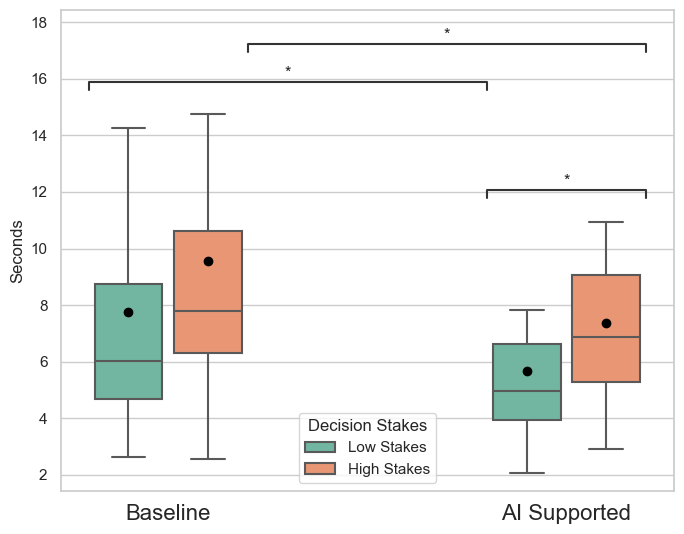

In [26]:
ticks = ['Baseline', 'AI Supported']
sub_labels = ['Decision Time']
columns =[['dec_time1', 'dec_time2']]


ind_pairs = [[(("dec_time1", "Low Stakes"), ("dec_time1", "High Stakes")),
              (("dec_time2", "Low Stakes"), ("dec_time2", "High Stakes"))]]

rel_pairs = [[(("dec_time1", "Low Stakes"), ("dec_time2", "Low Stakes")),
              (("dec_time1", "High Stakes"), ("dec_time2", "High Stakes"))]]


fig, axes = plt.subplots(1, 1, figsize=(7, 5.5), sharey=True)
axes = np.array([axes])

for ax, l, cs, mwu_ps, wil_ps in zip(axes.flatten(), sub_labels, columns, ind_pairs, rel_pairs):

  df_tmp = combined_df[cs + ['Decision Stakes']]
  melted_df = pd.melt(df_tmp, id_vars='Decision Stakes', value_vars=cs,
                      var_name='Feature', value_name='Value')

  box_plot = sns.boxplot(
      ax=ax,  data=melted_df, x='Feature', y='Value', hue='Decision Stakes',
      dodge='auto', width=0.4, fliersize=2, linewidth=1.5, palette='Set2', gap=0.15, 
      showfliers=False, showmeans=True, meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black')
      )
  # ax.set_title(l, fontsize=18)
  ax.set_xticks(ticks=np.arange(2), labels = ticks, fontsize=16)
  ax.set_xlabel('')
  ax.set_ylabel('Seconds')
  # ax.set_ylim([0, 20])

  # ax.legend(title='', loc='upper right', fontsize=16)

  mwu_pvals = []
  for p in mwu_ps:
    data1 = combined_df[p[0][0]][combined_df['Decision Stakes'] == p[0][1]]
    data2 = combined_df[p[1][0]][combined_df['Decision Stakes'] == p[1][1]]
    res = ttest_ind_neqvar(data1, data2)
    mwu_pvals.append(res.pvalue)

  wil_pvals = []
  for p in wil_ps:
    data1 = combined_df[p[0][0]][combined_df['Decision Stakes'] == p[0][1]]
    data2 = combined_df[p[1][0]][combined_df['Decision Stakes'] == p[1][1]]
    res = ttest_rel(data1, data2, alternative='two-sided')
    wil_pvals.append(res.pvalue)


  annotator = Annotator(ax, mwu_ps + wil_ps, data=melted_df, x='Feature', y='Value', hue='Decision Stakes')
  annotator.configure(test=None, text_format='star', loc='inside', verbose=2, hide_non_significant=True)
  annotator.set_pvalues(mwu_pvals + wil_pvals)
  annotator.annotate()

fig.tight_layout()


# plt.savefig('ijcai25/figures/decision-time.png', dpi=300)